In [10]:
import pandas as pd
import sqlite3
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import norm, lognorm, expon, gamma, weibull_min
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
con = sqlite3.connect("nokia.db")
df = pd.read_sql("SELECT * FROM Makkah_5g",con)

In [4]:
coordinates = df[['Longitude', 'Latitude']]

# Perform KMeans clustering
kmeans = KMeans(n_clusters=53, random_state=42)
df['Cluster'] = kmeans.fit_predict(coordinates)

# Update the Makkah_5g table with the new cluster information
for i, row in df.iterrows():
    query = f"""
    UPDATE Makkah_5g
    SET Cluster = {row['Cluster']}
    WHERE Longitude = {row['Longitude']} AND Latitude = {row['Latitude']}
    """
    con.execute(query)

# Commit the changes and close the connection
con.commit()
con.close()


<h1>visualize rsrp for each cluster<h1>

In [ ]:
import matplotlib.pyplot as plt

num_clusters = df['Cluster'].nunique()
df = df.dropna(subset=['RSRP (d Bm)-Dominant RSRP (d Bm) '])

for cluster in range(num_clusters):
    # Filter data for the current cluster
    cluster_data = df[df['Cluster'] == cluster]

    # Plot the distribution of RSRP values for this cluster
    plt.figure(figsize=(10, 6))
    plt.hist(cluster_data['RSRP (d Bm)-Dominant RSRP (d Bm) '], bins=20, alpha=0.7)
    plt.title(f'RSRP Distribution for Cluster {cluster}')
    plt.xlabel('RSRP (dBm)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


<h1>Find best distribution for each cluster<h1>

In [ ]:
num_clusters = df['Cluster'].nunique()
df = df.dropna(subset=['RSRP (d Bm)-Dominant RSRP (d Bm) '])

# Function to calculate AIC
def calculate_aic(log_likelihood, num_params):
    return 2 * num_params - 2 * log_likelihood

# List of distributions to fit
distributions = [norm, lognorm, expon, gamma, weibull_min]

for cluster in range(num_clusters):
    # Filter data for the current cluster
    cluster_data = df[df['Cluster'] == cluster]['RSRP (d Bm)-Dominant RSRP (d Bm) ']

    # Initialize variables to track the best distribution
    best_distribution = None
    best_aic = np.inf
    best_params = None

    # Fit each distribution to the cluster data
    for distribution in distributions:
        # Fit the distribution to the data
        params = distribution.fit(cluster_data)

        # Calculate the log-likelihood and AIC
        log_likelihood = np.sum(distribution.logpdf(cluster_data, *params))
        num_params = len(params)
        aic = calculate_aic(log_likelihood, num_params)

        # Update the best distribution if the current one has a lower AIC
        if aic < best_aic:
            best_aic = aic
            best_distribution = distribution
            best_params = params

    # Plot the histogram and the best-fitting distribution
    plt.figure(figsize=(10, 6))
    plt.hist(cluster_data, bins=20, density=True, alpha=0.6, color='g')

    # Plot the best fit distribution
    x = np.linspace(min(cluster_data), max(cluster_data), 100)
    pdf_fitted = best_distribution.pdf(x, *best_params)
    plt.plot(x, pdf_fitted, 'r-', label=f'{best_distribution.name} fit')

    plt.title(f'RSRP Distribution for Cluster {cluster}')
    plt.xlabel('RSRP (dBm)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'Cluster {cluster}: Best fit distribution: {best_distribution.name}, AIC: {best_aic}')
    print(f'Parameters: {best_params}')

<h1>Visualize the results of the distribution info added to the random forest and linear regression<h2>

Random Forest MSE: 13.28204922294385
Linear Regression MSE: 64.25657727575827


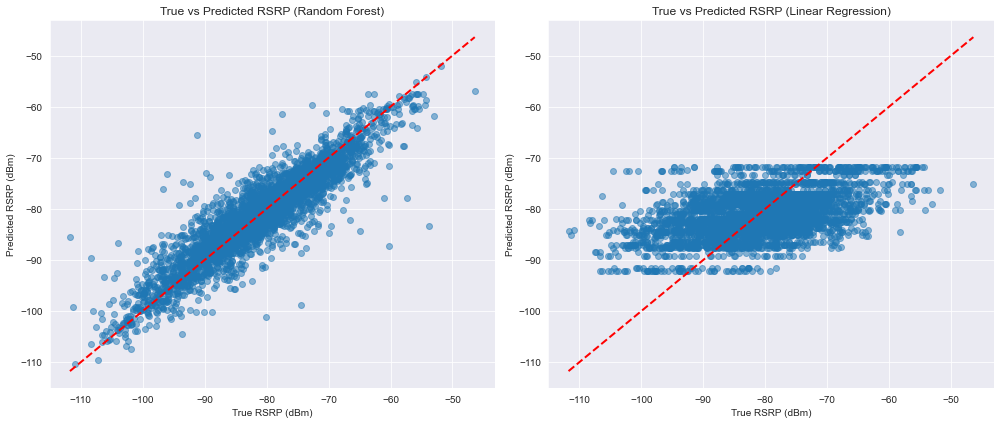

In [9]:
df = df.dropna(subset=['RSRP (d Bm)-Dominant RSRP (d Bm) '])

# Create a function to calculate distribution-based features
def extract_distribution_features(df, feature_col, cluster_col):
    cluster_stats = []

    for cluster in df[cluster_col].unique():
        cluster_data = df[df[cluster_col] == cluster][feature_col]
        stats = {
            'Cluster': cluster,
            'Mean': np.mean(cluster_data),
            'Variance': np.var(cluster_data),
            'Skewness': skew(cluster_data),
            'Kurtosis': kurtosis(cluster_data),
        }
        cluster_stats.append(stats)

    return pd.DataFrame(cluster_stats)

# Extract features based on the distribution of RSRP within each cluster
distribution_features = extract_distribution_features(df, 'RSRP (d Bm)-Dominant RSRP (d Bm) ', 'Cluster')

# Drop existing columns if they exist to avoid duplicates
df = df.drop(columns=['Mean', 'Variance', 'Skewness', 'Kurtosis'], errors='ignore')

# Merge these features back into the original DataFrame
df = df.merge(distribution_features, on='Cluster', how='left')

# Define the features and target for the regression model
X = df[['Mean', 'Variance', 'Skewness', 'Kurtosis', 'Longitude', 'Latitude']]
y = df['RSRP (d Bm)-Dominant RSRP (d Bm) ']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Evaluate the models
rf_mse = mean_squared_error(y_test, rf_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions)

print(f'Random Forest MSE: {rf_mse}')
print(f'Linear Regression MSE: {lr_mse}')

# Plot the true vs. predicted values for both models
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title('True vs Predicted RSRP (Random Forest)')
plt.xlabel('True RSRP (dBm)')
plt.ylabel('Predicted RSRP (dBm)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, lr_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title('True vs Predicted RSRP (Linear Regression)')
plt.xlabel('True RSRP (dBm)')
plt.ylabel('Predicted RSRP (dBm)')
plt.grid(True)

plt.tight_layout()
plt.show()


<h1>tuning<h1>

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/medoaljoudi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7

Best parameters found by GridSearchCV:
{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mean Squared Error of the best model: 13.422459985040552


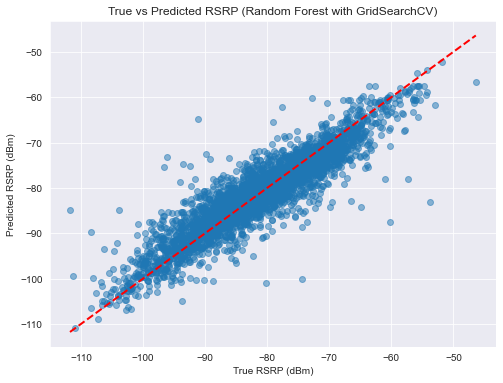

In [11]:
X = df[['Mean', 'Variance', 'Skewness', 'Kurtosis', 'Longitude', 'Latitude']]
y = df['RSRP (d Bm)-Dominant RSRP (d Bm) ']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],           # Number of trees
    'max_depth': [10, 20, 30, None],           # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],           # Minimum number of samples to split an internal node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error of the best model: {mse}")

# Plot the true vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title('True vs Predicted RSRP (Random Forest with GridSearchCV)')
plt.xlabel('True RSRP (dBm)')
plt.ylabel('Predicted RSRP (dBm)')
plt.grid(True)
plt.show()
